# Thumb rule and Markov chain Monte Carlo

The goal of this tutorial is to practice the Markov chain algorithm and to explore how
the statistical error of the result depends on specific choices for the
evolution of the configurations. We will focus on the simple example of the estimate for $\pi$
using uniformly distributed points over a square $[-1,1]^2$

<center>
<img src="https://gist.github.com/mferrero/ae328ab0e3a0d3d7181a007daf5a373a/raw/circle.png" width=300 height=300 />
</center>

An estimate for $\pi$ is obtained by counting the fraction of points that are inside the
unit radius circle:

$$
\pi \simeq 4\times\frac{N_{\mathrm{inside}}}{N_{\mathrm{total}}}
$$



Let's first import the relevant libraries once and for good.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

## Direct sampling

As a warm up, we will try to get an estimate for $\pi$ by direct uniform sampling. In other words,
we will directly generate (with uniform probability) random points within the $[-1,1]^2$
square and evaluate $\pi$ by looking at the fraction of points within the radius 1 circle.

### Statistical evaluation of $\pi$

Write a function that evaluates $\pi$ using a sample of $N$ points.
You can obtain a random pair of numbers in $[-1,1]$ with
```python
point = np.random.uniform(-1, 1, 2)
```

### Solution

Here is a possible way to write the function. I generate all the
points in one line with `np.random.uniform(-1, 1, [N, 2])`. This allows to have a faster code,
but of course it is completely fine to use a loop to generate the different points.

In [2]:
# compute pi estimate from uniform samples
def pi_uniform(N):
    
    points = np.random.uniform(-1, 1, [N, 2])
    dist = np.linalg.norm(points, axis=1)
    inside = np.sum(dist < 1)
    return 4 * inside / N
    
print("Estimate = ", pi_uniform(10000))

Estimate =  3.1592


### Statistical error bars

If you have time (you can do this at the end), you can try to compute the statistical error on the estimate
of $\pi$. To do so, generate several estimates (typically 100 or so) and compute
their standard deviation:

$$
  \sigma = \sqrt{ \langle \mathcal{O}^2 \rangle - \langle \mathcal{O} \rangle^2 }
$$

where $\mathcal{O}$ is the random variable used to estimate $\pi$. How does the
standard deviation depend on the number of sample points $N$?

### Solution

One can see that the error bar decreases as $\sigma_0 / \sqrt{N}$, where
$\sigma_0 = \sqrt{4\pi-\pi^2}$ is the standard deviation for a single sample.
This is basically nothing but an expression of the central limit theorem.

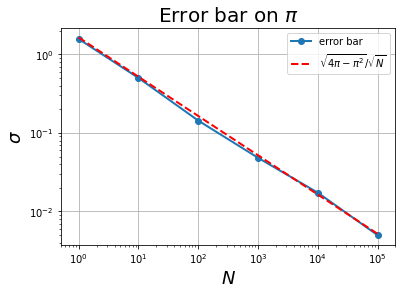

In [3]:
n_orders = 6
n_pts, error_bar = np.zeros(n_orders), np.zeros(n_orders)
n_samples = 100

# loop over n_orders orders of magnitude
for p in range(n_orders):
    
    N = np.power(10, p)    # number of points used to sample pi
    pi_estimates = np.zeros(n_samples)
    
    # compute pi estimates
    for i in range(n_samples):
        pi_estimates[i] = pi_uniform(N)

    n_pts[p] = N
    error_bar[p] = np.std(pi_estimates) # np.std computes the standard deviation

plt.loglog(n_pts, error_bar, '-o', lw=2, label='error bar')
plt.loglog(n_pts, np.sqrt(4*np.pi-np.pi**2)/np.sqrt(n_pts), 'r--', lw=2, label=r'$\sqrt{4\pi-\pi^2} / \sqrt{N}$')
plt.title("Error bar on $\pi$", fontsize=20)
plt.xlabel('$N$', fontsize=18)
plt.ylabel(r'$\sigma$', fontsize=18)
plt.grid()
plt.xlim(0.5, 2e5)
plt.legend()

## Markov chain algorithm

Direct sampling is in general very difficult to achieve. Even though it is easy for our
example to calculate $\pi$, let us pretend that we do not know how to do direct sampling.
We then need the more general strategy of a Markov chain algorithm. As you saw in the
lecture, the idea is to let a "walker" evolve over the surface of the square. At every
step the walker moves within a square $[-\delta, \delta]^2$ around its position, where
$\delta$ is a chosen maximal displacement length. If the displacement
would bring the walker out of the square, then we let the walker where it was and do not
move it. One of the questions we will try to answer is how we should choose the
parameter $\delta$.

### Statistical evaluation of $\pi$

Write a function that evaluates $\pi$ using a walker that will make a
total of $N$ steps.

### Solution

In [4]:
def pi_markov(N, delta):
    
    n_inside = 0
    walker = np.random.uniform(-1, 1, size=2)
    for i in range(N):
        shift = np.random.uniform(-delta, delta, size=2)
        new_walker = walker + shift
        if np.all(np.abs(new_walker) < 1): # we are inside the square
            walker = new_walker
        if np.linalg.norm(walker) < 1: # we are inside the circle
            n_inside += 1
            
    return 4 * n_inside / N

pi_markov(100000, 0.2)

3.18508

### Acceptance rate

We will be interested in how the algorithm performs for different values of $\delta$.
An important ingredient in that respect is the "acceptance rate". This is the fraction
of proposed moves that have led to a change of position of the walker (that have been accepted).
Modify your function so that it also computes and returns the acceptance rate.
How do you expect the acceptance rate to depend on $\delta$?

### Solution

This is a minor change of the previous code. By changing $\delta$ it clearly appears that the
acceptance rate has a tendency to diminish if $\delta$ is increased.

In [5]:
def pi_markov(N, delta):
    
    n_inside = 0
    n_accepted = 0
    walker = np.random.uniform(-1, 1, size=2)
    for i in range(N):
        shift = np.random.uniform(-delta, delta, size=2)
        new_walker = walker + shift
        if np.all(np.abs(new_walker) < 1): # we are inside the square
            walker = new_walker
            n_accepted += 1
        if np.linalg.norm(walker) < 1: # we are inside the circle
            n_inside += 1
            
    return 4 * n_inside / N, n_accepted / N

pi_markov(10000, 0.1)

(3.3108, 0.9543)

### Statistical error bars

Using the Markov chain algorithm, both the estimate for $\pi$ and the acceptance rate
have a statistical variance. It is interesting to study the standard deviation
(error bar) on these quantities. Write a new function that uses 200 samples to
estimate the standard deviation on the estimate for $\pi$ and on the
acceptance rate. Ideally, the function could return 4 numbers: the estimate
for pi, its standard deviation, the estimate of the acceptance rate, its
standard deviation. Remeber that because of the central limit theorem,
your error bar will be the standard deviation of your samples divided
by $\sqrt{N_\mathrm{samples}}$, i.e.

$$
 \sigma = \frac{1}{\sqrt{N_\mathrm{samples}}} \big[ \langle \mathcal{O}^2\rangle
 - \langle \mathcal{O} \rangle^2 \big]
$$

### Solution

In [6]:
def pi_markov_std(N, delta):
    
    n_samples = 200
    estimates = np.zeros([n_samples, 2])

    # compute n_samples estimates
    for i in range(n_samples):
        estimates[i,:] = pi_markov(N, delta)
        
    av = np.average(estimates, axis=0)
    err = np.std(estimates, axis=0) / np.sqrt(n_samples)
    return av[0], err[0], av[1], err[1]

pi_markov_std(100, 0.2)

(3.1532, 0.04475990169783664, 0.9077999999999997, 0.004132892449604755)

### Dependence on $\delta$

We are now in a position to investigate how the results depend on $\delta$.
Create and discuss the three following plots:

   * The estimate of $\pi$ versus $\delta$ (with error bars)
   * The acceptance rate versus $\delta$ (with error bars)
   * The error bar for $\pi$ versus $\delta$
   
The runs will start to take some time. So you may want to only take about
$N=100$ steps for the walker. You can investigate values of $\delta \in [0,4]$.
By looking at the behavior of the error bars, what can you say about the
optimal value that should be taken for $\delta$?

### Solution

Let us first generate all the data and create the plots later.

In [7]:
N = 100
deltar = np.linspace(0, 4, 20)
pi_av = np.zeros_like(deltar)
pi_err = np.zeros_like(deltar)
acc_av = np.zeros_like(deltar)
acc_err = np.zeros_like(deltar)

# this may take a bit of time
for i, delta in enumerate(deltar):
    pi_av[i], pi_err[i], acc_av[i], acc_err[i] = pi_markov_std(N, delta)

Inspecting the three plots we can draw the following conclusions:

   * We can see that the estimates for $\pi$ are all correct within error bars.
     The algorithm therefore provides statistically correct results for any choice
     of $\delta$. However, it is already apparent on the first plot that some
     values of $\delta$ seem to yield better statistical variance.
   * The acceptance rate gradually decreases with increasing $\delta$. This is
     not surprising. Also, the error bar on the acceptance rate is very small.
   * The error bar for $\pi$ clearly has a minimum versus $\delta$ as can be
     seen in the third plot. The location of the minimum (even if it is quite broad)
     is compatible with an acceptance rate close to 0.5.
     
These results are compatible with the **Thumb rule** that states that one should
chose the parameters in a Markov chain Monte Carlo in a way that the acceptance
rate is close to 0.5.

Text(0, 0.5, '$\\sigma$')

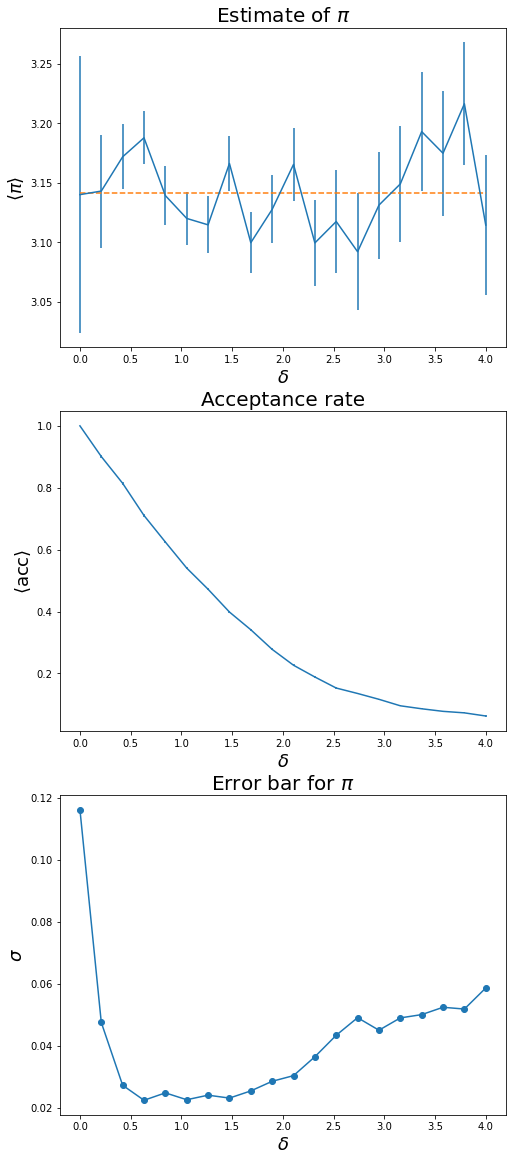

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(8,20))

ax[0].errorbar(deltar, pi_av, yerr=pi_err)
ax[0].plot(deltar, np.pi * np.ones_like(deltar), '--')
ax[0].set_title("Estimate of $\pi$", fontsize=20)
ax[0].set_xlabel("$\delta$", fontsize=18)
ax[0].set_ylabel(r"$\langle \pi \rangle$", fontsize=18)

ax[1].errorbar(deltar, acc_av, yerr=acc_err)
ax[1].set_title("Acceptance rate", fontsize=20)
ax[1].set_xlabel("$\delta$", fontsize=18)
ax[1].set_ylabel(r"$\langle \mathrm{acc} \rangle$", fontsize=18)


ax[2].plot(deltar, pi_err, '-o')
ax[2].set_title("Error bar for $\pi$", fontsize=20)
ax[2].set_xlabel("$\delta$", fontsize=18)
ax[2].set_ylabel(r"$\sigma$", fontsize=18)


### Optimal $\delta$ from the Thumb rule

We have now seen that the smallest statistical error bars are obtained when the acceptance
rate is close to 0.5. Use a bisection algorithm that will find a value of $\delta$ yielding
an acceptance rate in $[0.45, 0.55]$. Do not reinvent the wheel, you can use the `scipy` library
to do this:
```python
import scipy.optimize
scipy.optimize.bisect(f, a, b, xtol=0.05)
```
This function will find a zero of the function `f` between `a` and `b` with a tolerance
`xtol`.

### Solution


In [9]:
import scipy.optimize

N = 100
def f(delta):
    return pi_markov_std(N, delta)[2] - 0.5

optimal_delta = scipy.optimize.bisect(f, 0, 4, xtol=0.05)
print("Optimal delta = ", optimal_delta)

# Get final result from optimal delta
print("Final result = ", pi_markov_std(N, optimal_delta))

Optimal delta =  1.15625
Final result =  (3.1693999999999996, 0.02442290318532996, 0.5006999999999998, 0.004144580799067622)
